# Import Libraries

In [77]:
import os
import gc
import glob
import numpy as np
from tqdm import tqdm

# visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import segmentation_models_pytorch as smp

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
#TTA
#import ttach as tta

## Configuration

In [78]:
class CFG:
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
    img_size      = [960, 960]
    channels      = 3
    num_classes   = 1

    #Model Architecture
    model         = "UNet"
    encoder       = "efficientnet-b2"
    weights       = None


# Set Path

In [79]:
Inference_IMG_DIR = "../Datasets/Submit_Image"      
IMPORT_MODEL_DIR  = "../result/Train2_models"
SAVE_IMAGE_DIR    = "../result/submit_images"

### InferenceDataset

In [80]:
class InferenceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, os.listdir(self.image_dir)[index])   
        image = np.array(Image.open(img_path))
        img_name = os.listdir(self.image_dir)[index].split('.')[0]
        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
            
        return image, img_name

In [81]:
infer_transform = A.Compose(
    [
        A.Resize(*CFG.img_size),
        ToTensorV2()
    ], p=1.0
)

In [82]:
infer_ds = InferenceDataset(Inference_IMG_DIR,infer_transform)

infer_loader = DataLoader(
    infer_ds,
    batch_size=1,
    pin_memory=True,
    shuffle=False
)

### Load Model

In [83]:
def build_model():
    model = smp.Unet(
        encoder_name    = CFG.encoder,      
        encoder_weights = CFG.weights,     
        in_channels     = CFG.channels,                  
        classes         = CFG.num_classes,             
        activation      =None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

### Inference Function

In [84]:
@torch.no_grad()
def infer(model_paths, infer_loader, num_log=10):
    msks = []; imgs = [];
    for idx, (img, img_name) in enumerate(tqdm(infer_loader, total=len(infer_loader), desc='Infer ')):
        img = img.to(CFG.device, dtype=torch.float)#.squeeze()
        msk = []
        
        for path in model_paths:
            model = load_model(path)
            #tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
            out   = model(img).squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out).squeeze(0) # removing channel axis
            msk.append(out)
        msk = torch.mean(torch.stack(msk, dim=0), dim=0)
        msk = F.interpolate(msk[None,None,], size=(942, 1716), mode='nearest')[0,0]
        msk = msk.cpu().detach().numpy()
        msk = cv2.threshold(msk, 0.5, 255, cv2.THRESH_BINARY)[1].astype('uint8')      
        
        cv2.imwrite(f"{SAVE_IMAGE_DIR}/{img_name[0]}.png", msk)
        
        img = F.interpolate(img[0:1,], size=(942, 1716), mode='nearest')[0] # first dim is image w/o aug
        img = img.squeeze().permute((1,2,0)).cpu().detach().numpy()
        if idx<num_log:
            msks.append(msk)
            imgs.append(img)
        del img, msk
        gc.collect()
        torch.cuda.empty_cache()
    print("> Inference Done")
    return imgs, msks

## Inference

In [85]:
models_path = glob.glob(os.path.join(IMPORT_MODEL_DIR,"*.bin"))
print("Used models Path:",models_path)
imgs, msks = infer(models_path, infer_loader)

Used models Path: ['../result/Train2_models\\best_retrain_Fold00.bin', '../result/Train2_models\\best_retrain_Fold01.bin', '../result/Train2_models\\best_retrain_Fold02.bin']


Infer : 100%|██████████| 315/315 [04:55<00:00,  1.07it/s]

> Inference Done


### Visualize

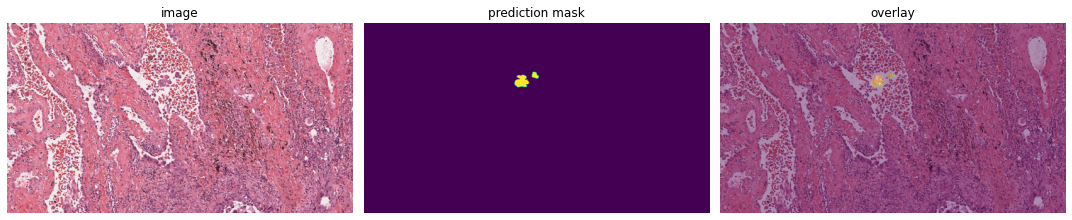

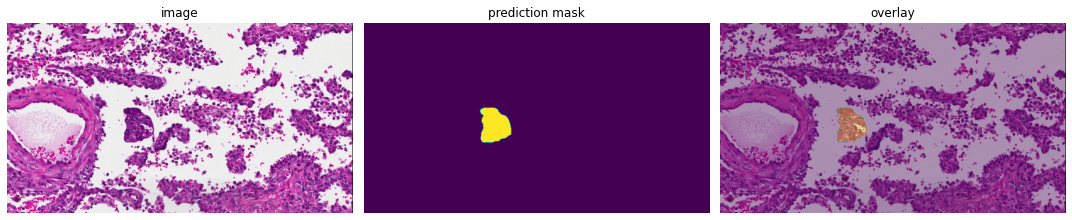

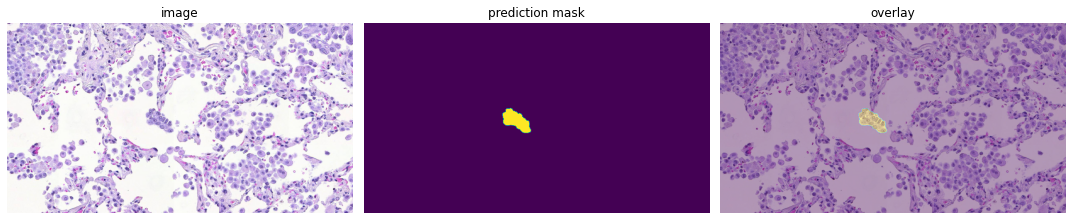

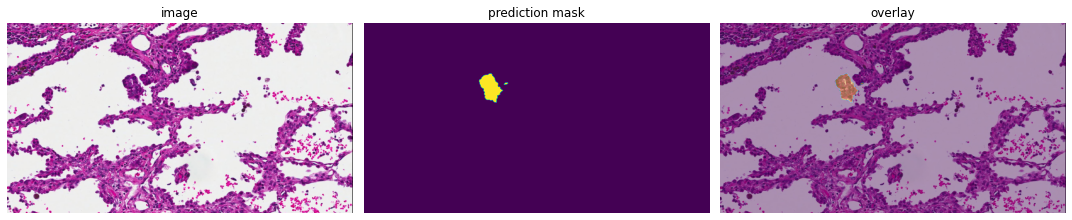

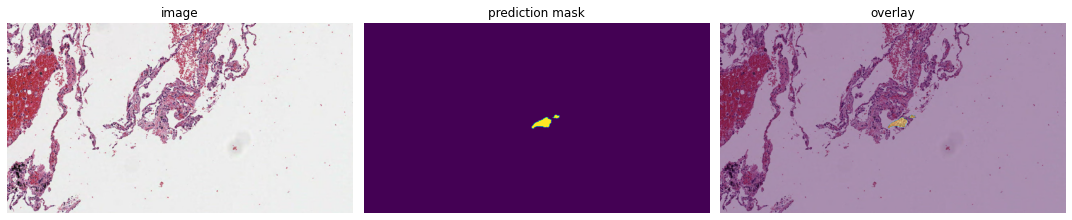

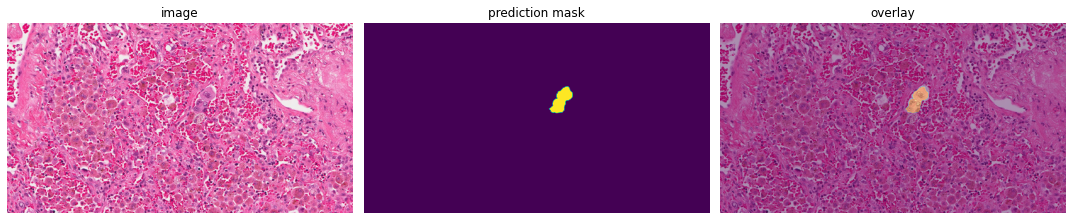

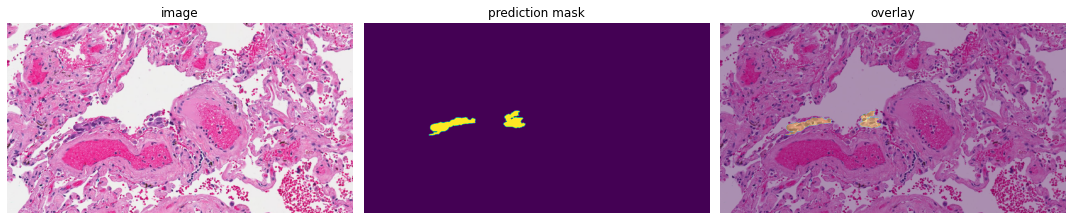

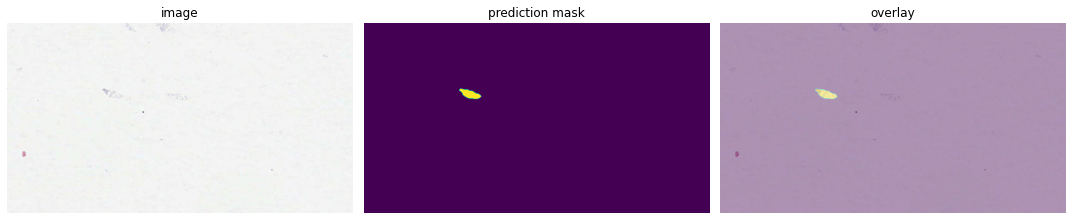

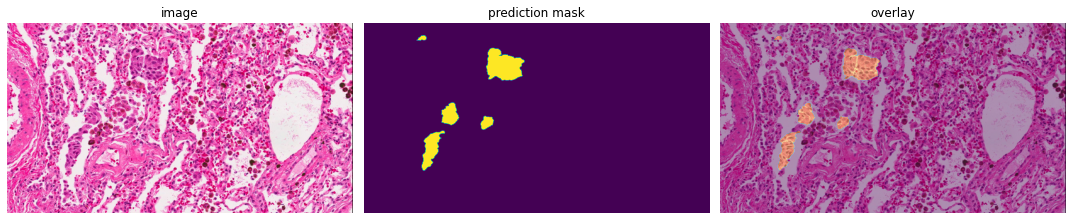

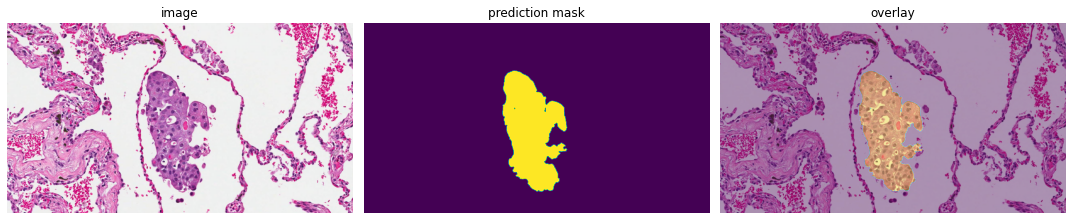

In [86]:
for img, msk in zip(imgs, msks):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1); plt.imshow(img.astype('uint8')); plt.axis('OFF'); plt.title('image')
    plt.subplot(1, 3, 2); plt.imshow(msk); plt.axis('OFF'); plt.title('prediction mask')
    plt.subplot(1, 3, 3); plt.imshow(img.astype('uint8')); plt.imshow(msk, alpha=0.4); plt.axis('OFF'); plt.title('overlay')
    plt.tight_layout()
    plt.show()